In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import time

import psydac.core.interface as inter

import utilitis_FEEC.derivatives as der
import utilitis_FEEC.projectors as proj
import utilitis_FEEC.evaluation as eva
import utilitis_FEEC.integrate as integr
import utilitis_FEEC.mass_matrices_curved as ma

In [2]:
# ... define boundary conditions in each direction (True: periodic, False: homogeneous Dirichlet)
bc = [False, True, True]
bc_x, bc_y, bc_z = bc


# ... length of computational domain in each direction
Lx = 1
Ly = 1
Lz = 1


# ... number of elements in each direction and corresponding element boundaries
Nel_x = 10
Nel_y = 10
Nel_z = 5

dx = Lx/Nel_x
dy = Ly/Nel_y
dz = Lz/Nel_z

el_b_x = np.linspace(0, Lx, Nel_x + 1)
el_b_y = np.linspace(0, Ly, Nel_y + 1)
el_b_z = np.linspace(0, Lz, Nel_z + 1)


# ... degree of spline basis (of the 0-forms) in each direction
p = [3, 3, 3]
px, py, pz = p


# ... number of basis functions
Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
Nbase_x, Nbase_y, Nbase_z = Nbase


# ... number of degrees of freedom
Nbase_x_0 = Nbase_x - bc_x*px - (1 - bc_x)*2
Nbase_y_0 = Nbase_y - bc_y*py - (1 - bc_y)*2
Nbase_z_0 = Nbase_z - bc_z*pz - (1 - bc_z)*2



# ... knot vectors
if bc_x == True:
    Tx = inter.make_periodic_knots(px, Nbase_x)
else:
    Tx = inter.make_open_knots(px, Nbase_x)
    
if bc_y == True:
    Ty = inter.make_periodic_knots(py, Nbase_y)
else:
    Ty = inter.make_open_knots(py, Nbase_y)
    
if bc_z == True:
    Tz = inter.make_periodic_knots(pz, Nbase_z)
else:
    Tz = inter.make_open_knots(pz, Nbase_z)
    
T = [Tx, Ty, Tz]



# ... define physical domain and mapping from logical domain
R1 = 0.2
R2 = 1.0
dR = R2 - R1

xc = lambda r, phi, z : (r*dR + R1)*np.cos(2*np.pi*phi)
yc = lambda r, phi, z : (r*dR + R1)*np.sin(2*np.pi*phi)
zc = lambda r, phi, z : z


g = lambda r, phi, z : 2*np.pi*dR*(r*dR + R1)
#g = lambda r, phi, z : 1.

G = [[lambda r, phi, z : dR**2, lambda r, phi, z : 0., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 4*np.pi**2*(r*dR + R1)**2, lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 0., lambda r, phi, z : 1.]]
#G = [[lambda r, phi, z : 1., lambda r, phi, z : 0., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 1., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 0., lambda r, phi, z : 1.]]

Ginv = [[lambda r, phi, z : 1/dR**2, lambda r, phi, z : 0., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 1/(4*np.pi**2*(r*dR + R1)**2), lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 0., lambda r, phi, z : 1.]]
#Ginv = [[lambda r, phi, z : 1., lambda r, phi, z : 0., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 1., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 0., lambda r, phi, z : 1.]]

# 1. Space $V_0$

In [13]:
# ... function to be projected
phi0 = lambda r, phi, z : r*(1 - r)*np.sin(4*np.pi*phi)*np.cos(2*np.pi*z)

In [14]:
# ... mass matrix in V0
M0 = ma.mass_matrix_V0(p, Nbase, T, g, bc)

In [15]:
# ... L2-scalar product in V0
phi0_int = ma.L2_prod_V0(phi0, p, Nbase, T, g, bc)

In [16]:
# ... solve system
phi0_vec = sparse.linalg.spsolve(M0, phi0_int)

Text(0.5,1,'projected')

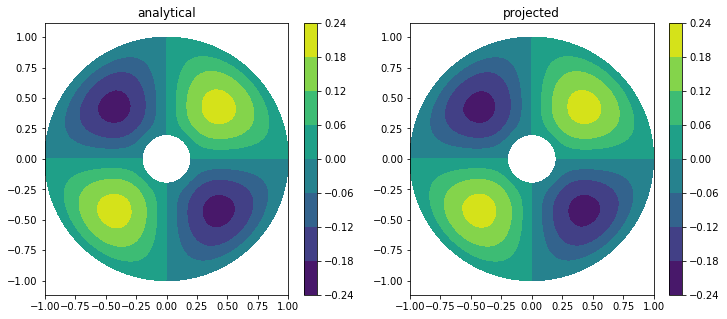

In [17]:
# ... plot analytical and numerical solution

zplot = np.array([0.1])
rplot = np.linspace(0., 1., 100)
phiplot = np.linspace(0., 1., 100)

R, PHI = np.meshgrid(rplot, phiplot, indexing = 'ij')

PHI0 = phi0(R, PHI, zplot)

PHI0_h = eva.evaluate_field_V0(phi0_vec, [rplot, phiplot, zplot], p, Nbase, T, bc)
PHI0_h = np.reshape(PHI0_h, (100, 100))

X, Y = xc(R, PHI, zplot), yc(R, PHI, zplot)

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.subplot(1, 2, 1)

plt.contourf(X, Y, PHI0)
plt.colorbar()
plt.axis('equal')
plt.title('analytical')


plt.subplot(1, 2, 2)

plt.contourf(X, Y, PHI0_h)
plt.colorbar()
plt.axis('equal')
plt.title('projected')

# 2. Space $V_1$

In [61]:
# ... vector field to be projected
phi1_r   = lambda r, phi, z : np.cos(2*np.pi*phi)
phi1_phi = lambda r, phi, z : r*(1 - r)
phi1_z   = lambda r, phi, z : np.sin(2*np.pi*phi)

phi1 = [lambda r, phi, z : phi1_r(r, phi, z)*dR*np.cos(2*np.pi*phi) - phi1_phi(r, phi, z)*(r*dR + R1)*np.sin(2*np.pi*phi)*2*np.pi, lambda r, phi, z : phi1_r(r, phi, z)*dR*np.sin(2*np.pi*phi) + phi1_phi(r, phi, z)*(r*dR + R1)*np.cos(2*np.pi*phi)*2*np.pi, lambda r, phi, z : phi1_z(r, phi, z)]

In [62]:
# ... mass matrix in V1
M1 = ma.mass_matrix_V1(p, Nbase, T, Ginv, g, bc)

In [63]:
# ... L2-scalar product in V1
phi1_int = ma.L2_prod_V1(phi1, p, Nbase, T, Ginv, g, bc)

In [64]:
# ... solve system
phi1_vec = sparse.linalg.spsolve(M1, phi1_int)

phi1_vec_x = phi1_vec[:600]
phi1_vec_y = phi1_vec[600:1150]
phi1_vec_z = phi1_vec[1150:]

Text(0.5,1,'numerical y')

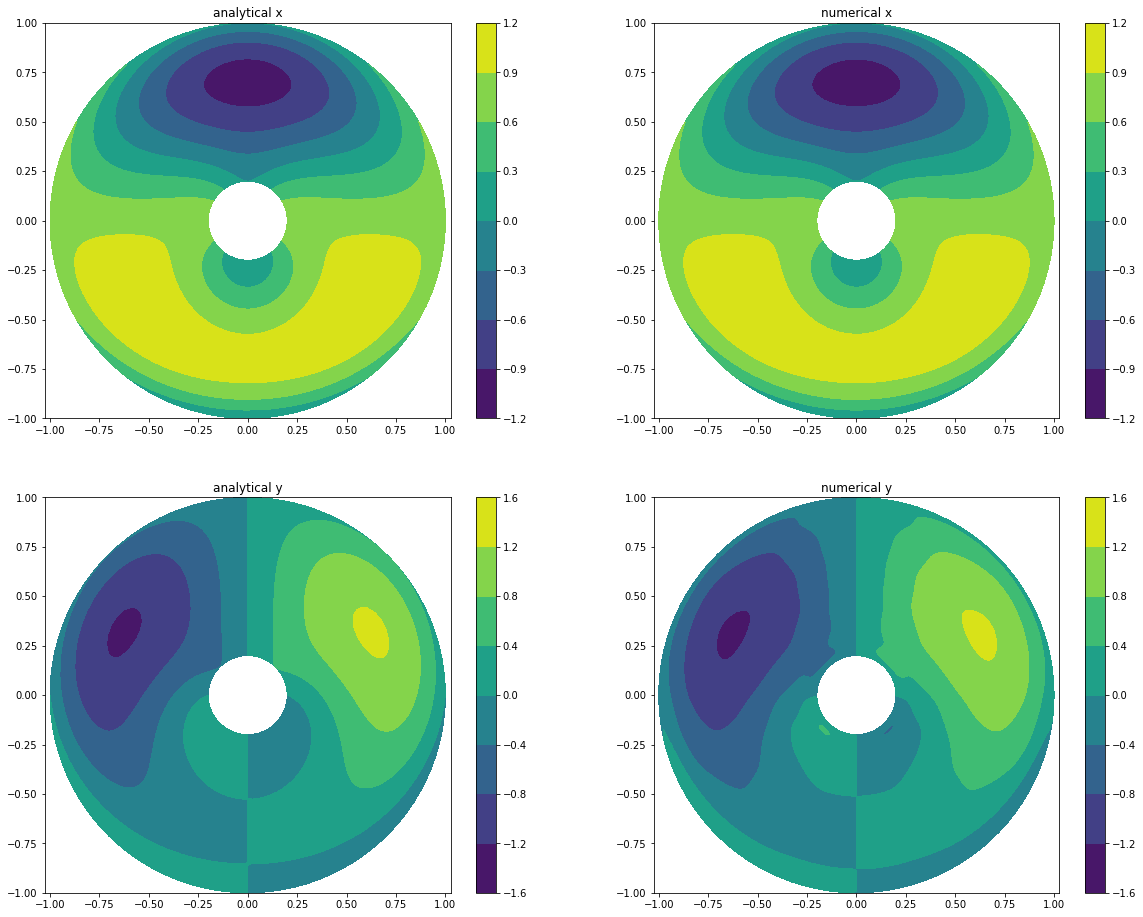

In [65]:
# ... plot analytical and numerical solution

zplot = np.array([0.1])
rplot = np.linspace(0., 1., 100)
phiplot = np.linspace(0., 1., 100)

R, PHI = np.meshgrid(rplot, phiplot, indexing='ij')

PHI1_x = phi1[0](R, PHI, zplot)
PHI1_y = phi1[1](R, PHI, zplot)

PHI1_h_x = eva.evaluate_field_V1_x(phi1_vec_x, [rplot, phiplot, zplot], p, Nbase, T, bc)
PHI1_h_y = eva.evaluate_field_V1_y(phi1_vec_y, [rplot, phiplot, zplot], p, Nbase, T, bc)

PHI1_h_x = np.reshape(PHI1_h_x, (100, 100))
PHI1_h_y = np.reshape(PHI1_h_y, (100, 100))

X, Y = xc(R, PHI, zplot), yc(R, PHI, zplot)

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(16)

plt.subplot(2, 2, 1)

plt.contourf(X, Y, PHI1_x)
plt.colorbar()
plt.axis('equal')
plt.title('analytical x')

plt.subplot(2, 2, 2)

plt.contourf(X, Y, PHI1_h_x)
plt.colorbar()
plt.axis('equal')
plt.title('numerical x')


plt.subplot(2, 2, 3)

plt.contourf(X, Y, PHI1_y)
plt.colorbar()
plt.axis('equal')
plt.title('analytical y')

plt.subplot(2, 2, 4)

plt.contourf(X, Y, PHI1_h_y)
plt.colorbar()
plt.axis('equal')
plt.title('numerical y')

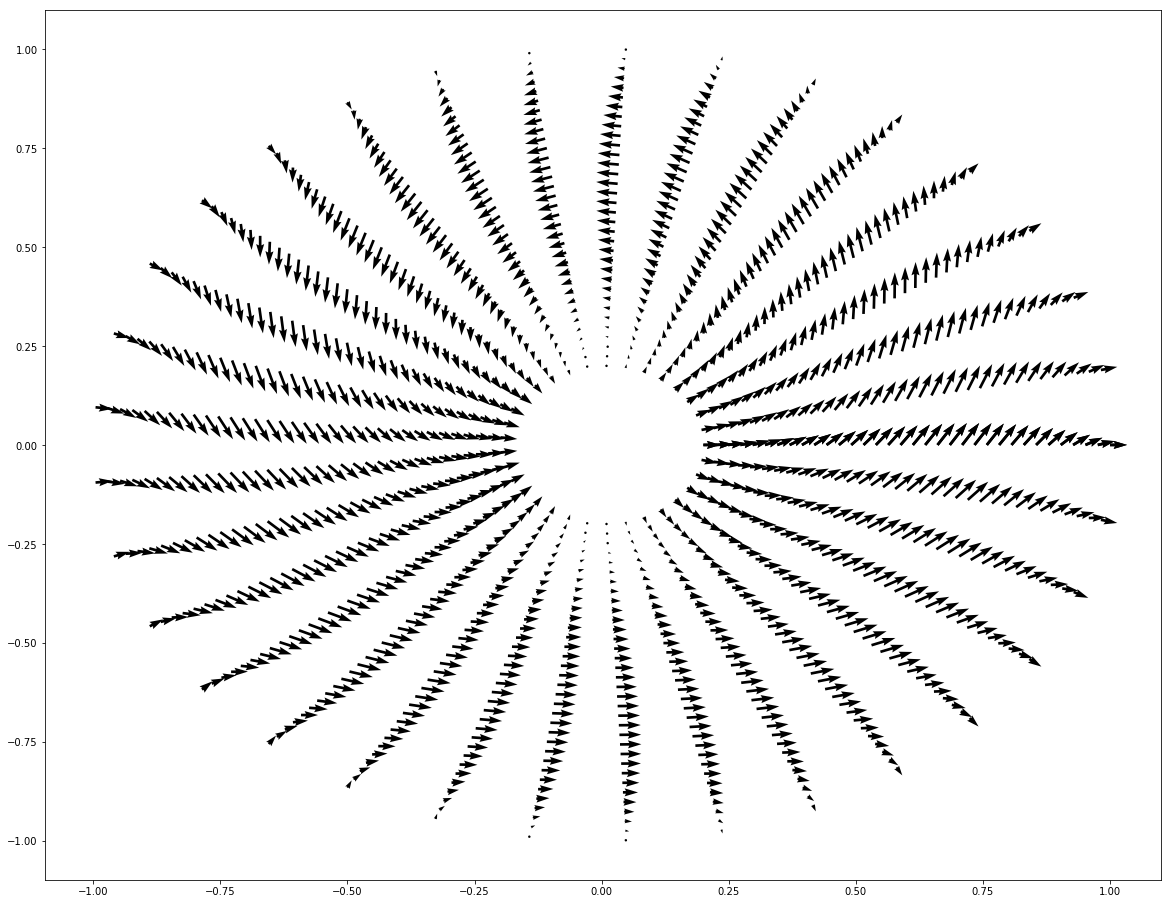

In [60]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(16)

s = 3
plt.quiver(X[::s, ::s], Y[::s, ::s], PHI1_x[::s, ::s], PHI1_y[::s, ::s])

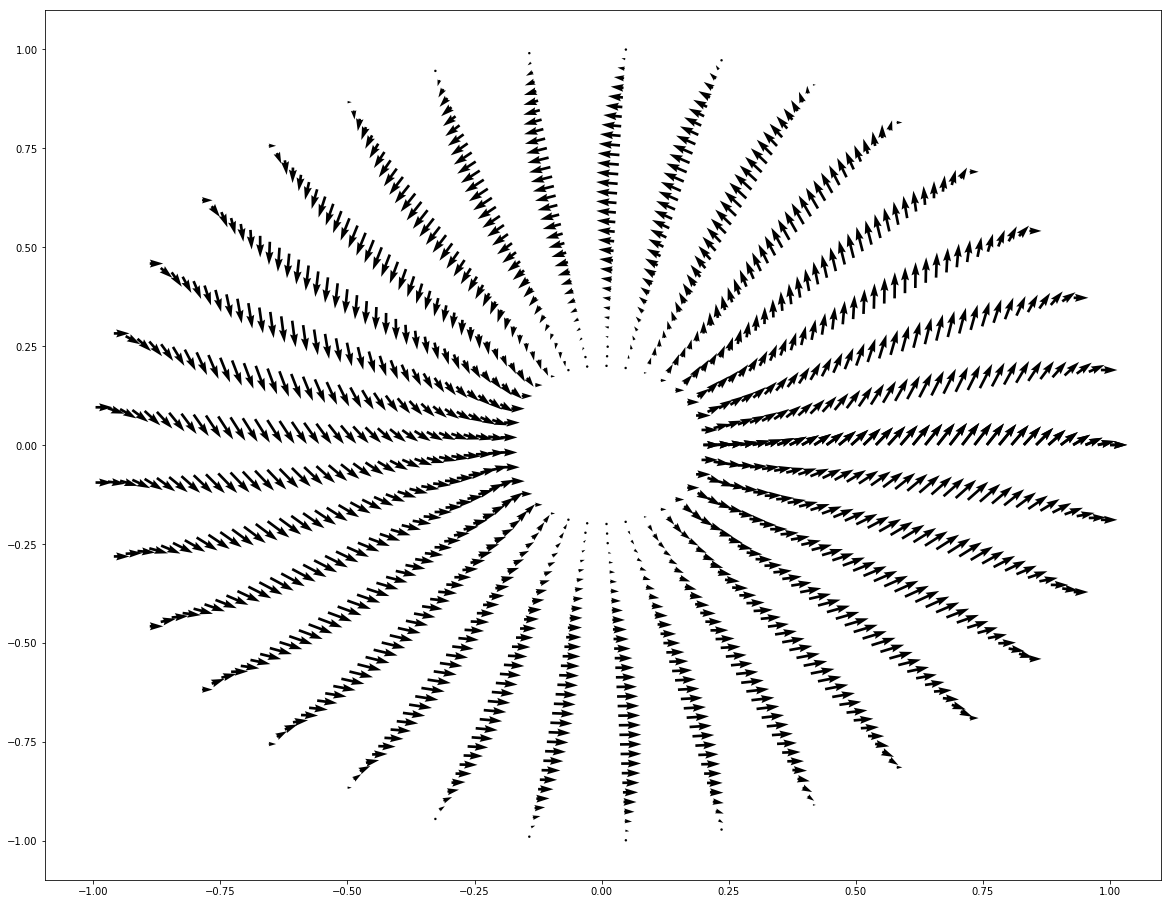

In [66]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(16)

s = 3
plt.quiver(X[::s, ::s], Y[::s, ::s], PHI1_h_x[::s, ::s], PHI1_h_y[::s, ::s])